In [ ]:
# default_exp load_model

# Load Model

In [ ]:
#export
import torch 
import yaml
from fastcore.script import *
from swfd.resources import *
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

NORMALIZE=707.6
HORIZONS=[3,5,7,10,14,21,27]
COLUMNS=['Date','H3','H5','H7','H10','H14','H21','H27']

In [ ]:
#hide
#To make test execute this line 
from swfd.web_scraping import fixValues
datatest=fixValues([ ['2021-05-20',"-1"] , ['2021-05-18',"75"], ['2021-05-14',"55" ],['2021-05-11',"50" ],['2021-05-1',"130" ]
             ,['2021-04-1',"145" ],['2021-03-1',"170" ],['2021-02-1',"130" ],['2021-01-1',"150" ],['2020-12-1',"150" ]])
path=getInfo("csvdirectory")+"sfuData.csv"
df = pd.DataFrame(datatest, columns= ['Date', 'Sfu'])
df.to_csv(path, header = False, index = False)

loadModel(pathrun): Funcion que pasándole la dirección de una run saca su modelo

In [ ]:
#export
def loadModel(pathrun):
    pathyaml=str(pathrun)+"config.yaml"
    stacktype=[]
    pathpth=str(pathrun)+"models/best.pth"
    config=yaml.safe_load(open(str(pathyaml)))
    for i in range(0,config["nb_stacks"]["value"]):
        stacktype.append(NBeatsNet.GENERIC_BLOCK)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NBeatsNet(
                  device=device,
                  stack_types=stacktype,
                  nb_blocks_per_stack=config["nb_blocks_per_stack"]["value"],
                  forecast_length=config["horizon"]["value"],
                  backcast_length=config["lookback"]["value"],
                  thetas_dim=(7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8),
                  share_weights_in_stack=False,
                  hidden_layer_units=64
                  #,nb_harmonics=None
                  )
    checkpoint = torch.load(pathpth,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model


In [ ]:
#hide
pathmodeltest="../test/pth/ensembleH5/sweep_run_1/"
modeltest=loadModel(pathmodeltest)
modeltest

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


NBeatsNet(
  (parameters): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 64x30]
      (1): Parameter containing: [torch.FloatTensor of size 64]
      (2): Parameter containing: [torch.FloatTensor of size 64x64]
      (3): Parameter containing: [torch.FloatTensor of size 64]
      (4): Parameter containing: [torch.FloatTensor of size 64x64]
      (5): Parameter containing: [torch.FloatTensor of size 64]
      (6): Parameter containing: [torch.FloatTensor of size 64x64]
      (7): Parameter containing: [torch.FloatTensor of size 64]
      (8): Parameter containing: [torch.FloatTensor of size 7x64]
      (9): Parameter containing: [torch.FloatTensor of size 7x64]
      (10): Parameter containing: [torch.FloatTensor of size 30x7]
      (11): Parameter containing: [torch.FloatTensor of size 30]
      (12): Parameter containing: [torch.FloatTensor of size 5x7]
      (13): Parameter containing: [torch.FloatTensor of size 5]
      (14): Parameter containing: [torch

formatdate(date): Convierte una fecha dada a el formato del csv

In [ ]:
#export
def formatDate(date):
    return date.strftime("%Y-%m-%d")

In [ ]:
#hide
print(formatDate(datetime.datetime.now()))
print(formatDate(datetime.datetime(1996,5,2)))
print(formatDate(datetime.datetime.now()-datetime.timedelta(1)))

2021-05-23
1996-05-02
2021-05-22


getCsvData(lookback):Funcion que devuelve el numero de valores de sfu empezando en 'start' dias atras, "lookback" veces. En caso de que la lista no este actualizada al día elegido devolverá una lista vacía.

In [ ]:
#export
#Default startdate = yesterday
def getCsvData(lookback,startdate=(datetime.datetime.now()-datetime.timedelta(1)) ):
    pathfoldercsv=getInfo("csvdirectory")
    csvname="sfuData.csv" 
    datalist=[]
    date=formatDate(startdate)
    start=False
    try:       
        with open(str(pathfoldercsv)+str(csvname)) as csv_file:
            try:
                forecastcount=0
                for row in list(csv.reader(csv_file, delimiter=',')):
                    if(date==row[0]):
                        start=True
                    if(forecastcount<lookback and start):
                        datalist=np.append(datalist,float(row[1]))
                        forecastcount=forecastcount+1
            finally:
                csv_file.close()
    except (IOError, ValueError, EOFError) as e:
          print(e) 
    return datalist


In [ ]:
#hide
#La siguiente prueba se ha hecho con la lista desactualizada
print(getCsvData(10))#10 primeros valores desde el día actual

datetest=datetime.datetime(2021, 5, 9)
print(getCsvData(3,datetest))#3 valores a partir del 'datetest' dia, este incluido

[75.  75.  75.  75.  75.  65.  60.  57.5 55.  52.5]
[110. 120. 125.]


getNameRunFolders(horizon,runshorizonfolder): Funcion que devuelve lista con el directorio de todas las carpetas de un horizonte

In [ ]:
#export
def getNameRunFolders(horizon,runshorizonfolder): 
    runshorizon_directories=runshorizonfolder+"ensembleH"+str(horizon)
    runs_directories=[] #runshorizon_directories
    directories = os.listdir(str(runshorizon_directories))
    for i in directories:
        pathrun=runshorizon_directories+"/"+str(i)+"/"
        runs_directories.append(pathrun)
    
    return runs_directories


In [ ]:
#hide
getNameRunFolders(5,"../test/pth/") 

['../test/pth/ensembleH5/sweep_run_3/',
 '../test/pth/ensembleH5/sweep_run_5/',
 '../test/pth/ensembleH5/sweep_run_4/',
 '../test/pth/ensembleH5/sweep_run_1/',
 '../test/pth/ensembleH5/sweep_run_2/']

singlePrediction(path,normalize): Funcion que hace la prediccion de una run concreta(carpeta individual)
    
    -Parámetro 'stardate' se escoge como día anterio al gendate, primer día que se recoge los datos para hacer la predicción para el día 'gendate'

In [ ]:
#export
# Startdate!=gendate stardate=daybefore(gendate)
def singlePrediction(filepath,startdate):
    net=loadModel(str(filepath))
    lookback=net.backcast_length
    data=getCsvData(lookback,startdate)
    row = torch.Tensor([data[::-1]/NORMALIZE])
    backcast,forecast = net(row)
    preds_tensor=(forecast.detach().numpy())*NORMALIZE
    return preds_tensor[0].reshape(1,net.forecast_length)


In [ ]:
#hide
pathmodeltest="../test/pth/ensembleH5/sweep_run_1/"
startdatetest=(datetime.datetime(2021, 5, 20))
predicttest=singlePrediction(pathmodeltest,startdatetest)
print(predicttest,type(predicttest),predicttest.shape)

[[ 87.32632  95.41866  99.68195 103.5785  109.00631]] <class 'numpy.ndarray'> (1, 5)


ensemblePrediction(path,normalize): Funcion que se recorre cada carpeta de un horizonte y hace la predicción para cada run, devolviendo una lista con todas las predicciones.

In [ ]:
#export
def ensemblePrediction(horizon,startdate):
    prediction=np.empty((0,horizon))
    folderpath=getInfo("pthdirectory")
    runspath=getNameRunFolders(horizon,folderpath)
    for run in runspath:
        prediction=np.append(prediction,singlePrediction(run,startdate),axis=0)
    return prediction

In [ ]:
#hide
startdatetest=(datetime.datetime(2021, 5, 20))
predicttest=ensemblePrediction(5,startdatetest)
print(predicttest)

[[ 89.29093933  95.76554871 100.53663635 106.24641418 106.1818161 ]
 [ 87.75797272  94.04647827  99.12280273 105.79450226 110.38280487]
 [ 82.13555145  83.86204529  90.07997894  91.73855591  99.80027771]
 [ 87.32631683  95.41866302  99.68195343 103.57849884 109.00630951]
 [ 81.93759155  87.74050903  93.76879883  98.62945557 102.76904297]]


ensembleMeanVar(prediction): Funcion que hace la media y varianza de los valores predichos

In [ ]:
#export
def ensembleMeanVar(prediction):
    meanlist=[]
    stdlist=[]
    for row in prediction.T:
        meanlist.append(row.mean())
        stdlist.append(row.std())
    return np.array(meanlist),np.array(stdlist)

In [ ]:
#hide
startdatetest=(datetime.datetime(2021, 5, 20))
predicttest=ensemblePrediction(5,startdatetest)
ensembleMeanVar(predicttest)

(array([ 85.68967438,  91.36664886,  96.63803406, 101.19748535,
        105.62805023]),
 array([3.05402951, 4.74169989, 4.04670775, 5.44719369, 3.91059686]))

modelPrediction(forecast): Funcion general que invoca a las demas funciones para cargar y ver el modelo

In [ ]:
#export
def modelPrediction(horizon,startdate):
    prediction=ensemblePrediction(horizon,startdate)   
    mean,std=ensembleMeanVar(prediction)
    return prediction,mean,std 


In [ ]:
#hide
forecasttest=5
startdatetest=(datetime.datetime(2021, 5, 20))
globalpredicttest,meantest,stdtest=modelPrediction(forecasttest,startdatetest)
print("----Mean----\n",meantest,"\n\n----Std----\n",stdtest,"\n\n----Predict----\n",globalpredicttest)

----Mean----
 [ 85.68967438  91.36664886  96.63803406 101.19748535 105.62805023] 

----Std----
 [3.05402951 4.74169989 4.04670775 5.44719369 3.91059686] 

----Predict----
 [[ 89.29093933  95.76554871 100.53663635 106.24641418 106.1818161 ]
 [ 87.75797272  94.04647827  99.12280273 105.79450226 110.38280487]
 [ 82.13555145  83.86204529  90.07997894  91.73855591  99.80027771]
 [ 87.32631683  95.41866302  99.68195343 103.57849884 109.00630951]
 [ 81.93759155  87.74050903  93.76879883  98.62945557 102.76904297]]


getAllHorizonPrediction: Función que devuelve en un array las predicciones de cada horizonte en una fecha determinada

In [ ]:
#export 
def getAllHorizonPrediction(date):
    allpredicts=[]
    allpredicts.append(date)
    for horizon in HORIZONS:
        try:
                predict=ensemblePrediction(horizon,date)
                mean,std=ensembleMeanVar(predict)
                allpredicts.append([mean,std])
        except TypeError: #Excepcion que salta con fecha invalida
                print("error en horizonte",horizon, " el dia",date)
                allpredicts.append([])
    return np.matrix(allpredicts,dtype="object")


In [ ]:
#hide
testallpredict1=getAllHorizonPrediction(datetime.datetime(2021, 5, 20))
testallpredict2=getAllHorizonPrediction(datetime.datetime(2021, 5, 19))
testallpredict3=getAllHorizonPrediction(datetime.datetime(2021, 5, 18))
testallpredict4=getAllHorizonPrediction(datetime.datetime(2021, 5, 17))
df = pd.DataFrame(columns=COLUMNS)

df1 = pd.DataFrame (testallpredict1,columns=COLUMNS)
df2 = pd.DataFrame (testallpredict2,columns=COLUMNS)
df3 = pd.DataFrame (testallpredict3,columns=COLUMNS)
df4 = pd.DataFrame (testallpredict4,columns=COLUMNS)

df=df.append(df1)
df=df.append(df2)
df=df.append(df3)
df=df.append(df4)
df.reset_index(drop=True, inplace=True)
(df)

,Date,H3,H5,H7,H10,H14,H21,H27
0,2021-05-20,"[[81.21248168945313, 86.84930114746093, 90.730...","[[85.6896743774414, 91.3666488647461, 96.63803...","[[88.08998107910156, 91.18880462646484, 97.142...","[[86.47946166992188, 91.7086410522461, 99.8507...","[[98.36115264892578, 98.92632293701172, 103.43...","[[103.5103759765625, 98.6413803100586, 111.403...","[[100.23645782470703, 102.5992660522461, 106.1..."
1,2021-05-19,"[[79.1148452758789, 84.64676513671876, 89.8692...","[[84.84960632324218, 90.60640106201171, 97.151...","[[88.34898376464844, 91.91641998291016, 98.310...","[[85.222900390625, 91.44981384277344, 99.83406...","[[98.57737731933594, 100.28819274902344, 106.5...","[[102.22454833984375, 97.90068054199219, 110.4...","[[97.27412414550781, 100.40276336669922, 105.6..."
2,2021-05-18,"[[77.24601287841797, 82.04307403564454, 87.805...","[[82.9322738647461, 89.56397552490235, 95.4848...","[[89.31147003173828, 91.42094421386719, 97.182...","[[84.14317321777344, 91.30431365966797, 99.914...","[[96.60798645019531, 98.28929138183594, 107.74...","[[97.37294006347656, 94.68815612792969, 106.97...","[[93.70542907714844, 95.90367889404297, 101.94..."
3,2021-05-17,"[[69.76936645507813, 74.02055511474609, 79.464...","[[75.6918441772461, 82.5073471069336, 88.62305...","[[81.01795196533203, 80.90645599365234, 90.064...","[[81.79053497314453, 88.2459487915039, 97.7942...","[[91.79501342773438, 90.76585388183594, 102.00...","[[89.51701354980469, 88.32717895507812, 99.790...","[[87.9896469116211, 89.56783294677734, 97.1685..."


showModel(): Función para mostrar graficamente la predicción de un horizonte obtenido en jupyter, por motivo de documentación para el TFG

In [ ]:
#hide
def showModel(horizon,gendate):
      
    lookback=int(horizon*6)  
    data=getCsvData(lookback*2,gendate+datetime.timedelta(lookback))[::-1]
    
    predict,mean,std=modelPrediction(horizon,gendate)
    
    recordtlist=[]
    for i in range(-lookback,lookback):
        recordtlist.append(i)
    forecastlist=[]
    for i in range(0,horizon):
        forecastlist.append(i)
    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("horizon"+str(horizon))
    
    ax1.plot(recordtlist,data,"r--") 
    ax1.plot(forecastlist,mean)
    ax1.fill_between(forecastlist, mean-std, mean+std,alpha=0.5)
    
    ax2.plot(recordtlist[lookback:lookback*2-1],data[lookback:lookback*2-1],"r--") 
    ax2.plot(forecastlist,mean)
    ax2.fill_between(forecastlist, mean-std, mean+std,alpha=0.5)
    
    print(pd.DataFrame(np.array([mean, data[lookback:lookback+horizon]]),index= ['Predict', 'Real'],columns= None))
    
    
    plt.show()


                  0           1           2           3           4
Predict  147.431314  147.959024  149.518692  149.950534  151.236551
Real     144.985352  144.970703  144.941406  144.882812  144.765625


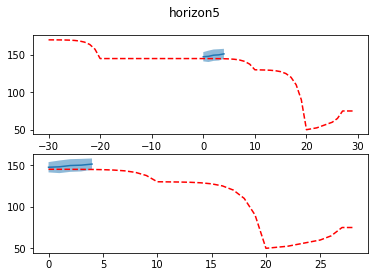

In [ ]:
#hide
# *Esto es un test de un modelo incompleto con datos artificiales y modificados de forma exponencial
showModel(5 ,datetime.datetime(2021,4,20))

In [ ]:
"""
showModel(5,datetime.datetime(2012,11,4))
"""


'\nshowModel(5,datetime.datetime(2012,11,4))\n'

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Valores reales: [81.7 83.8 79.6 85.8 86.4 87.4 87.7 87.9 87.8 87.2 84.2 82.8 81.2 80.4
 81.5 80.4 77.6]
Valores predichos:  [41.05318449 41.40047095 37.31370802]


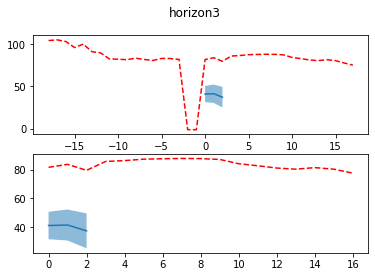

In [ ]:
"""
showModel2(3,datetime.datetime(2020,12,18))
"""

168 168
Valores reales: [81.7 83.8 79.6 85.8 86.4 87.4 87.7 87.9 87.8 87.2 84.2 82.8 81.2 80.4]
Valores predichos:  [51.2132083  52.93858469 54.73020227 57.09834983 59.06129979 62.78686371
 65.22266642 68.83135774 70.65906128 72.80046692 75.19950443 76.71211056
 77.83909895 77.87548794]


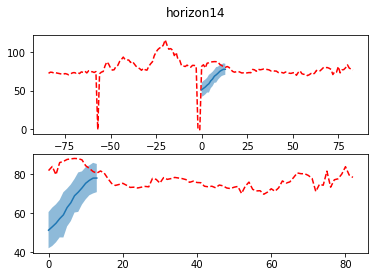

In [ ]:
#showModel(14,datetime.datetime(2020,12,18))

showModels(): Función para mostrar graficamente las predicciones de todos los horizontes obtenidos en jupyter, por motivo de documentación para el TFG

In [ ]:
#hide
#Funcion temporal para mostrar todo los modelos de un horizonte
def showModels(gendate):
    showModel(3,gendate)
    showModel(5,gendate)
    showModel(7,gendate)
    showModel(10,gendate)
    showModel(14,gendate)
    showModel(21,gendate)
    showModel(27,gendate)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                 0          1           2
Predict  94.516764  96.149333   97.399217
Real     96.600000  98.700000  101.700000


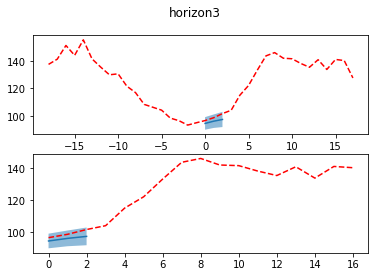

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                 0          1           2           3           4
Predict  96.180394  98.105792  100.743239  103.091624  106.624864
Real     96.600000  98.700000  101.700000  104.100000  115.100000


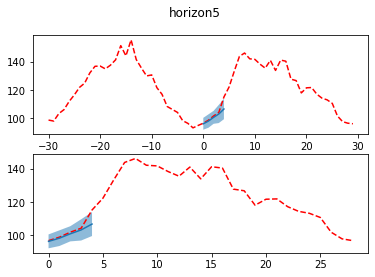

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                 0          1           2           3           4           5  \
Predict  97.123219  98.680064  101.864752  105.263055  108.242265  111.962234   
Real     96.600000  98.700000  101.700000  104.100000  115.100000  122.200000   

                  6  
Predict  114.386022  
Real     133.300000  


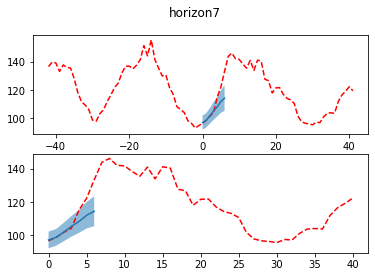

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                 0          1           2           3           4           5  \
Predict  97.824654  99.632647  103.154232  106.250465  109.475826  113.495218   
Real     96.600000  98.700000  101.700000  104.100000  115.100000  122.200000   

                  6           7           8           9  
Predict  116.287679  119.452937  122.338628  124.808219  
Real     133.300000  143.800000  146.200000  142.100000  


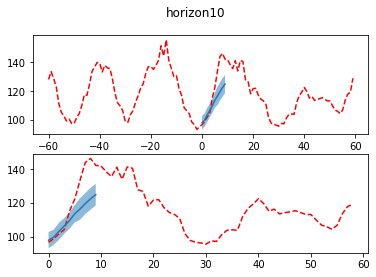

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                0           1           2           3           4   \
Predict  97.310862  100.076475  102.401925  106.075167  109.580541   
Real     96.600000   98.700000  101.700000  104.100000  115.100000   

                 5           6           7           8           9   \
Predict  113.423676  117.427349  120.511184  123.430494  125.082554   
Real     122.200000  133.300000  143.800000  146.200000  142.100000   

                 10         11          12          13  
Predict  127.004672  128.92482  128.506457  127.858217  
Real     141.700000  138.30000  135.500000  141.000000  


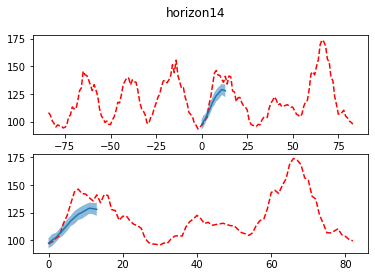

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                0         1           2           3           4           5   \
Predict  97.589377  99.85631  102.642509  106.194905  109.054651  112.526357   
Real     96.600000  98.70000  101.700000  104.100000  115.100000  122.200000   

                 6           7           8           9   ...          11  \
Predict  116.454846  119.629236  122.008714  125.565286  ...  127.656818   
Real     133.300000  143.800000  146.200000  142.100000  ...  138.300000   

                 12         13          14          15          16  \
Predict  128.483994  128.23146  126.224119  125.772906  123.919419   
Real     135.500000  141.00000  133.900000  141.200000  140.400000   

                 17         18        19          20  
Predict  121.080888  118.94361  116.0457  114.395402  
Real     127.700000  126.70000  118.0000  121.600000  

[2 rows x 21 columns]


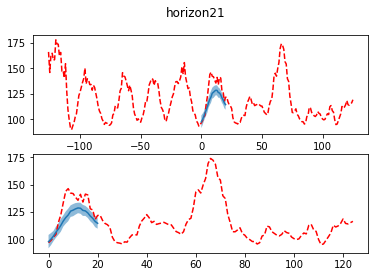

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                0           1           2           3           4   \
Predict  99.273356  100.345029  102.689252  105.233176  109.470695   
Real     96.600000   98.700000  101.700000  104.100000  115.100000   

                 5         6           7           8           9   ...  \
Predict  111.884991  115.0464  119.294088  120.759992  123.463313  ...   
Real     122.200000  133.3000  143.800000  146.200000  142.100000  ...   

                17          18          19          20         21         22  \
Predict  120.52089  118.279041  115.025247  113.033844  110.45165  109.45993   
Real     127.70000  126.700000  118.000000  121.600000  121.80000  117.10000   

                 23          24         25          26  
Predict  107.865684  106.577945  105.89501  105.505851  
Real     114.300000  113.100000  110.60000  101.700000  

[2 rows x 27 columns]


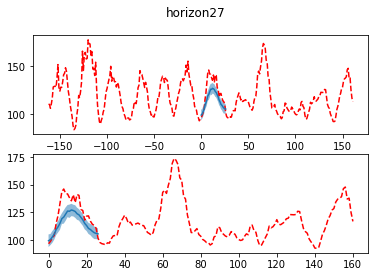

In [ ]:
#showModels(datetime.datetime(2012,11,4))

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


36 36
Valores reales: [119.5 115.  116.2]
Valores predichos:  [122.97628632 124.41514816 124.06090512]


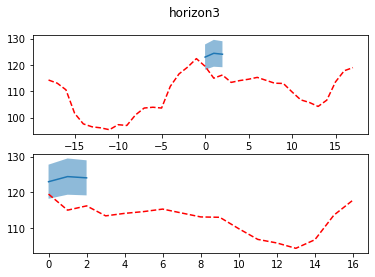

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


60 60
Valores reales: [119.5 115.  116.2 113.4 114.1]
Valores predichos:  [124.04450539 124.71527659 125.05621965 123.63380178 122.92856547]


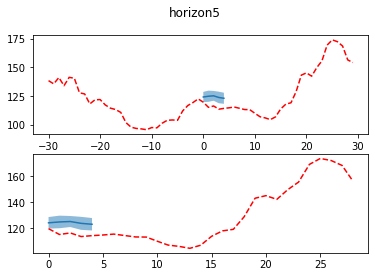

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


84 84
Valores reales: [119.5 115.  116.2 113.4 114.1 114.6 115.3]
Valores predichos:  [124.19342872 124.71061062 124.7404313  124.01182522 122.27296812
 120.85052694 118.10916943]


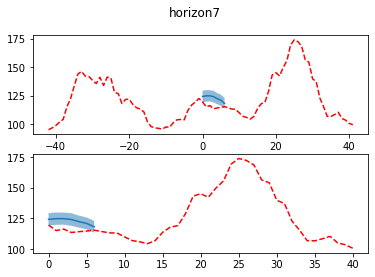

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


120 120
Valores reales: [119.5 115.  116.2 113.4 114.1 114.6 115.3 114.2 113.1 113. ]
Valores predichos:  [124.54248216 124.86371519 125.12969098 123.61623849 121.81915097
 120.14156604 117.02680206 115.05530497 113.03419529 110.68859058]


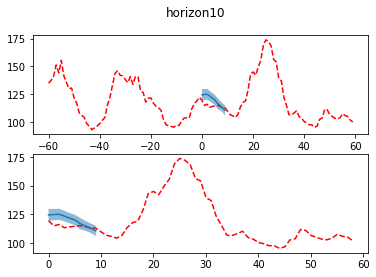

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


168 168
Valores reales: [119.5 115.  116.2 113.4 114.1 114.6 115.3 114.2 113.1 113.  109.8 106.8
 105.8 104.3]
Valores predichos:  [123.39366472 124.27388246 123.00207019 121.89236721 119.77318014
 117.92185872 115.72824936 112.96437378 110.46735967 107.94662425
 105.87644196 105.00892266 103.22532976 102.32053401]


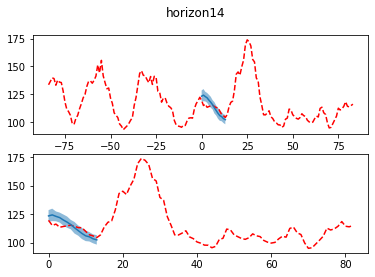

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


252 252
Valores reales: [119.5 115.  116.2 113.4 114.1 114.6 115.3 114.2 113.1 113.  109.8 106.8
 105.8 104.3 106.7 113.6 117.8 119.  128.8 143.1 145.1]
Valores predichos:  [123.5585439  124.02834871 123.25426932 122.42719727 120.78682878
 118.05998849 116.15123893 113.82809253 110.53644536 108.68947322
 106.59564014 104.91240353 103.99139633 102.65058043 102.07406048
 102.40617778 103.13397293 103.89561607 105.59561301 106.51737094
 108.72383126]


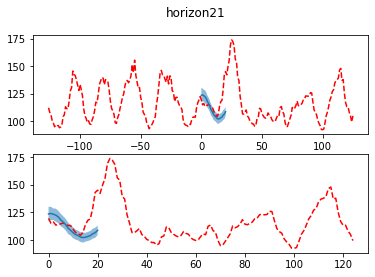

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


324 324
Valores reales: [119.5 115.  116.2 113.4 114.1 114.6 115.3 114.2 113.1 113.  109.8 106.8
 105.8 104.3 106.7 113.6 117.8 119.  128.8 143.1 145.1 142.2 149.7 155.6
 169.3 173.9 172.3]
Valores predichos:  [125.21652629 125.07958789 122.93939963 122.32128025 121.07128847
 118.2757264  115.85737449 114.31537637 111.43268399 108.83316803
 106.8531317  105.44975281 104.10957201 103.29132495 102.62991706
 102.40849686 103.52293642 104.53160299 106.21325404 106.95165736
 109.0832762  111.10212936 113.28596768 114.67072313 116.5080129
 118.22650214 118.93128365]


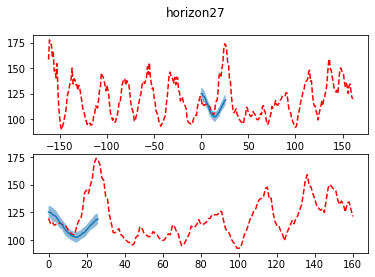

In [ ]:
#showModels(datetime.datetime(2012,12,15))

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                  0           1           2
Predict  114.414505  114.722908  116.398422
Real     119.000000  128.800000  143.100000


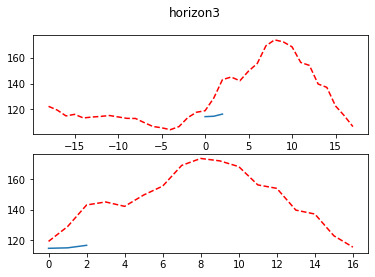

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                  0          1           2           3           4
Predict  119.799747  120.73535  121.335515  121.774872  122.420065
Real     119.000000  128.80000  143.100000  145.100000  142.200000


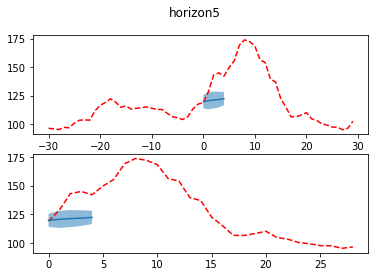

                  0           1           2           3           4  \
Predict  120.388336  120.838982  122.703583  122.750732  123.015434   
Real     119.000000  128.800000  143.100000  145.100000  142.200000   

                  5           6  
Predict  123.195221  122.882027  
Real     149.700000  155.600000  


/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


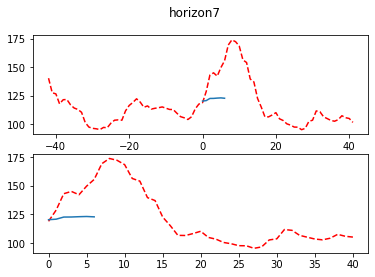

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                  0           1           2           3          4  \
Predict  117.774757  118.685196  120.117607  120.289299  121.10997   
Real     119.000000  128.800000  143.100000  145.100000  142.20000   

                  5           6           7           8           9  
Predict  123.333214  122.803284  123.885139  124.402359  123.439072  
Real     149.700000  155.600000  169.300000  173.900000  172.300000  


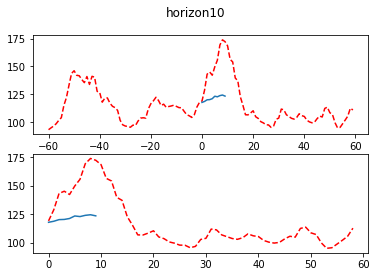

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                0          1           2           3           4           5   \
Predict  122.77021  126.88327  128.031708  127.842949  126.866608  128.334854   
Real     119.00000  128.80000  143.100000  145.100000  142.200000  149.700000   

                 6           7           8           9           10  \
Predict  127.334473  132.113571  126.403236  127.707603  126.657639   
Real     155.600000  169.300000  173.900000  172.300000  168.500000   

                11          12          13  
Predict  127.46682  124.867073  123.621254  
Real     156.40000  154.100000  139.700000  


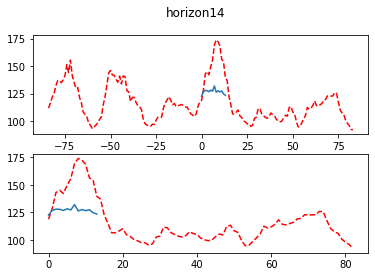

                 0           1           2           3           4   \
Predict  119.860306  119.867386  122.508286  126.393051  124.863235   
Real     119.000000  128.800000  143.100000  145.100000  142.200000   

                 5           6           7           8           9   ...  \
Predict  128.274902  127.921417  129.789597  128.270203  129.672913  ...   
Real     149.700000  155.600000  169.300000  173.900000  172.300000  ...   

                11          12          13         14          15          16  \
Predict  128.63176  123.606087  127.651718  121.83416  120.510025  123.237389   
Real     156.40000  154.100000  139.700000  137.10000  122.700000  115.200000   

                 17          18          19          20  
Predict  118.209969  119.489037  120.937729  118.300636  
Real     106.700000  106.600000  108.300000  110.300000  

[2 rows x 21 columns]


/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


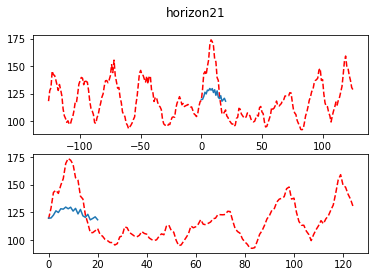

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


                 0           1           2           3           4   \
Predict  118.731369  117.174004  125.246811  125.306015  123.812599   
Real     119.000000  128.800000  143.100000  145.100000  142.200000   

                 5           6           7           8           9   ...  \
Predict  126.734428  126.706718  124.218704  122.956367  122.218384  ...   
Real     149.700000  155.600000  169.300000  173.900000  172.300000  ...   

                 17          18          19          20          21  \
Predict  115.712837  114.424995  115.717743  114.650711  116.231323   
Real     106.700000  106.600000  108.300000  110.300000  104.900000   

                 22          23         24          25          26  
Predict  114.406334  113.621368  115.55558  115.379349  116.070992  
Real     103.400000  100.500000   99.40000   97.700000   97.600000  

[2 rows x 27 columns]


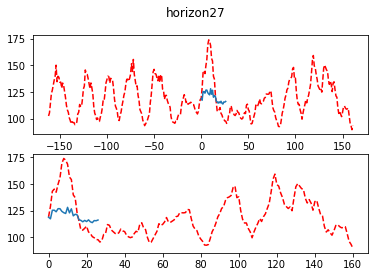

In [ ]:
#showModels(datetime.datetime(2013,1,1))